In [1]:
import os
import json
import imageio
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

from lib import utils, triplane_dvgo

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import matplotlib.pyplot as plt
%matplotlib inline

Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/adam_upd_cuda/build.ninja...
Building extension module adam_upd_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module adam_upd_cuda...
Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/render_utils_cuda/build.ninja...
Building extension module render_utils_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module render_utils_cuda...
Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /ho

In [5]:
model_class = triplane_dvgo.DirectVoxGO
ckpt_path = 'logs/triplane_only_singlescene/hotdog/fine_last.tar'
model = utils.load_model(model_class, ckpt_path).to(device)

dvgo: set density bias shift to -4.595119850134584

dvgo: voxel_size       4096000
dvgo: voxel_size       tensor(0.0369)
dvgo: world_size       tensor([170, 170, 140])
dvgo: voxel_size_base  tensor(0.0369)
dvgo: voxel_size_ratio tensor(1.)
dvgo: feature voxel grid xy torch.Size([1, 12, 170, 170])
dvgo: mlp Sequential(
  (0): Linear(in_features=39, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (3): Linear(in_features=128, out_features=3, bias=True)
)
False


RuntimeError: Error(s) in loading state_dict for DirectVoxGO:
	Missing key(s) in state_dict: "density", "rgbnet.0.weight", "rgbnet.0.bias", "rgbnet.2.0.weight", "rgbnet.2.0.bias", "rgbnet.3.weight", "rgbnet.3.bias". 
	Unexpected key(s) in state_dict: "rgbnet.pts_linears.0.weight", "rgbnet.pts_linears.0.bias", "rgbnet.pts_linears.1.weight", "rgbnet.pts_linears.1.bias", "rgbnet.pts_linears.2.weight", "rgbnet.pts_linears.2.bias", "rgbnet.views_linears.0.weight", "rgbnet.views_linears.0.bias", "rgbnet.feature_linear.weight", "rgbnet.feature_linear.bias", "rgbnet.density_linear.weight", "rgbnet.density_linear.bias", "rgbnet.rgb_linear.weight", "rgbnet.rgb_linear.bias". 

In [3]:
def resize(feat):
    feat = F.interpolate(feat, (200, 200), mode='bilinear', align_corners=True)
    return feat

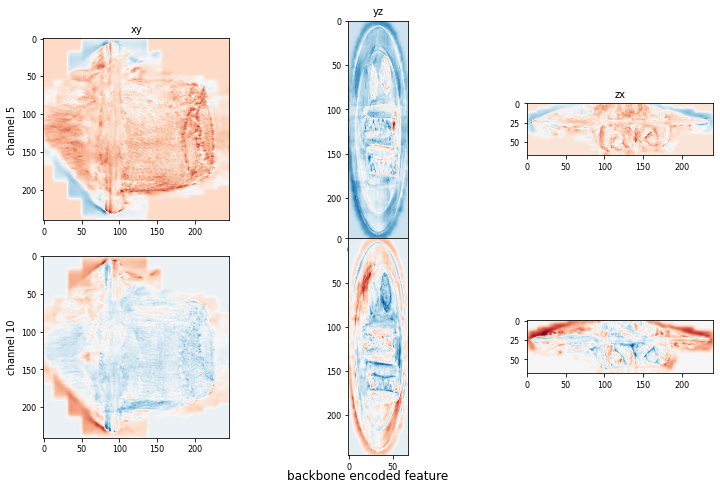

In [4]:
splits = ['xy','yz','zx']
channels = [5, 10]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
k0 = {}
for i, s in enumerate(splits):
    k0[s] = (model.k0[s] - model.k0[s].min()) / (model.k0[s].max() - model.k0[s].min())
    
    vmin = min(k0[s].min().item(), vmin)
    vmax = max(k0[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(k0[s][0][channel].detach().cpu().numpy(), cmap='RdBu')
#         axes[i, j].imshow(resize(k0[s])[0][channel].detach().cpu().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = splits
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.suptitle('backbone encoded feature', y=0.1)
plt.show()